# Health Insurance Analysis Across America
## PSTAT 134 Final Project


>Authors: Michael Hanson, Maya Samet, Alex Yam

We are starting here with 10,000 randomly sampled observations from the combined persons and family surveys. NOTE: REPLICATE THIS PROCESS IN THIS NOTEBOOK


Our question: What percentage of a household's total income is spent on health insurance?


Variables of Interest: 

- HICOSTR1 - amount spent on insurance plan
- HICOSTR2 - amount spent on second insurance plan, if any 
- Demographics, region, illnesses, month, number of people in the household, age (only looking at 18 or greater)
- ERNYR_P - amount earned annually (bracketted estimate)

To do:
- Generate two "illness" variables with a sum of illness people suffered 
- Generate variable for % income spent on insurance 
- Isolate the columns of interest for disease status and generate 1's and 0's 
- Generate key for our dataset
- Recreate merging and sampling process that you did in R 
- Remove all duration variables. 
- Start canva file for poster
- COME UP WITH A NARRATIVE - WHAT DRIVES INSURANCE PREMIUMS

Insurance spending is bound to 
- fluctuate over the course of a year
- Sum of it will increase over the course of a year

Notes on variables
- Those starting with QC are all flags (e.g. flag for all those that are 18 and over, flag for all children)
- Those starting with LA are all duration (remove them all)
- Those starting with SS are key - they say whether or not certain things are covered by insurance
- Those starting with PLNPAY are flags for which entity pays for health insurance
- Those starting with PLN are about insurance
- Those ending with FLG are flags
- Those starting with LC pertain to whether or not someone has a certain disease

Numeric
- HICOSTR1 (except for 99997, 99998, 99999 which should be NAs)
- HICOSTR2 (except for 99997, 99998, 99999 which should be NAs)
- The rest are categorical

In [183]:
import pandas as pd 
import numpy as np 
import plotly
import seaborn as sns
import matplotlib as plt
from sklearn import preprocessing
import urllib, json
from pandas.io.json import json_normalize
import random

In [119]:
df = pd.read_csv("person_family_10k.csv")
df.head()

,Unnamed: 0,HHX,FMX,SRVY_YR,FPX,AGE_CHG,INTV_QRT,SEX,NOWAF,FSPOUS2,...,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,33245,3221,1,2017,1,NaN,1,1,2.0,NaN,...,4.0,1,1,2,1.0,2,2,1,NaN,1.0
1,15907,20785,1,2017,1,NaN,2,1,2.0,NaN,...,4.0,1,1,1,2.0,1,2,1,2.0,2.0
2,35584,33706,1,2017,1,NaN,3,1,2.0,NaN,...,NaN,0,2,2,NaN,2,1,1,2.0,0.0
3,34389,3295,1,2017,3,NaN,1,2,NaN,NaN,...,4.0,1,2,2,NaN,2,5,1,2.0,5.0
4,1504,11086,1,2017,3,NaN,1,2,NaN,NaN,...,NaN,1,1,1,1.0,2,2,1,NaN,NaN


As we can see, first column is just the observation number. We can delete it

In [120]:
df = df.drop(columns=["Unnamed: 0"], axis=1) 
df.head()

,HHX,FMX,SRVY_YR,FPX,AGE_CHG,INTV_QRT,SEX,NOWAF,FSPOUS2,COHAB1,...,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,3221,1,2017,1,NaN,1,1,2.0,NaN,NaN,...,4.0,1,1,2,1.0,2,2,1,NaN,1.0
1,20785,1,2017,1,NaN,2,1,2.0,NaN,2.0,...,4.0,1,1,1,2.0,1,2,1,2.0,2.0
2,33706,1,2017,1,NaN,3,1,2.0,NaN,NaN,...,NaN,0,2,2,NaN,2,1,1,2.0,0.0
3,3295,1,2017,3,NaN,1,2,NaN,NaN,NaN,...,4.0,1,2,2,NaN,2,5,1,2.0,5.0
4,11086,1,2017,3,NaN,1,2,NaN,NaN,NaN,...,NaN,1,1,1,1.0,2,2,1,NaN,NaN


Drop a few more unnecessary columns:

In [121]:
df = df.drop(columns=['SRVY_YR', 'PSTRAT', 'PPSU', 'AGE_CHG', 'RRP', 'HHREFLG',
                      'FMRPFLG', 'FMREFLG'])
df[df["HICOSTR1"]>20000]=np.NaN
df.head()

,HHX,FMX,FPX,INTV_QRT,SEX,NOWAF,FSPOUS2,COHAB1,COHAB2,FCOHAB3,...,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,3221.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,...,4.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,NaN,1.0
1,20785.0,1.0,1.0,2.0,1.0,2.0,NaN,2.0,NaN,2.0,...,4.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0
2,33706.0,1.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,0.0,2.0,2.0,NaN,2.0,1.0,1.0,2.0,0.0
3,3295.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,4.0,1.0,2.0,2.0,NaN,2.0,5.0,1.0,2.0,5.0
4,11086.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,2.0,2.0,1.0,NaN,NaN


# Exploratory Data Analysis

[(0, 20000), Text(0.5, 1.0, 'Insurance premium costs over race and sex')]

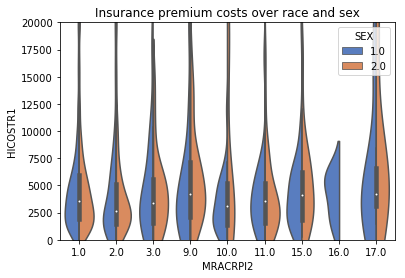

In [122]:
ax = sns.violinplot(x="MRACRPI2", y="HICOSTR1", hue="SEX", data=df, palette="muted", split=True)
ax.set(ylim=(0, 20000), title="Insurance premium costs over race and sex")

[(0, 20000),
 Text(0.5, 1.0, 'Insurance premium costs for Hispanic vs Non-Hispanic')]

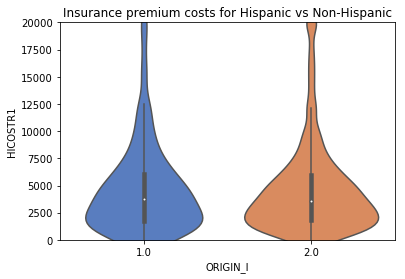

In [123]:
ax = sns.violinplot(x="ORIGIN_I", y="HICOSTR1", data=df, palette="muted", split=False)
ax.set(ylim=(0, 20000), title="Insurance premium costs for Hispanic vs Non-Hispanic")

# Alluvial Plot - Illnesses & Insurance Premium Brackets

In [124]:
# create filter that will give us all disease flag variables
illness_filter = [col for col in df if col.startswith('LAHC') or col.startswith('PLA')]

# create new df for this task, change responses to a simple y/n, sum to check how many people suffer from each disease
df_alluvial = df
df_alluvial[illness_filter] = df_alluvial[illness_filter].replace([2,3,4,5,6,7,8,9,np.NaN], 0)
df_alluvial[illness_filter].sum()

PLAPLYLM     17.0
PLAPLYUN     11.0
PLAADL      213.0
PLAIADL     322.0
PLAWKNOW    567.0
PLAWKLIM    359.0
PLAWALK     472.0
PLAREMEM    284.0
LAHCC1        4.0
LAHCC2        6.0
LAHCC3       43.0
LAHCC4        8.0
LAHCC5       14.0
LAHCC6        2.0
LAHCC8       28.0
LAHCC9       48.0
LAHCC10       8.0
LAHCC11       4.0
LAHCC12      48.0
LAHCC13      42.0
LAHCC90       9.0
LAHCC91       0.0
LAHCA1       91.0
LAHCA2       68.0
LAHCA3      266.0
LAHCA4      325.0
LAHCA5      107.0
LAHCA6       39.0
LAHCA7      130.0
LAHCA8       55.0
LAHCA9      132.0
LAHCA10     142.0
LAHCA11      97.0
LAHCA12      52.0
LAHCA13      15.0
LAHCA15      17.0
LAHCA16      60.0
LAHCA17     206.0
LAHCA18      53.0
LAHCA90      33.0
LAHCA91       0.0
LAHCA19_     13.0
LAHCA20_    177.0
LAHCA21_     43.0
LAHCA22_     37.0
LAHCA23_    121.0
LAHCA24_     33.0
LAHCA25_     39.0
LAHCA26_      5.0
LAHCA27_      1.0
LAHCA28_     10.0
LAHCA29_      0.0
LAHCA30_     24.0
LAHCA31_     10.0
LAHCA32_     17.0
LAHCA33_  

As we can see, for many diseases our n count is less than 30. Let's filter it so we have n>30

In [125]:
alluvial_bool = df_alluvial[illness_filter].sum()>30
new_illness_filter = alluvial_bool[alluvial_bool==1].index.values
df_alluvial = df_alluvial.drop(alluvial_bool[alluvial_bool==0].index.values, axis=1)
df_alluvial[new_illness_filter].sum()

PLAADL      213.0
PLAIADL     322.0
PLAWKNOW    567.0
PLAWKLIM    359.0
PLAWALK     472.0
PLAREMEM    284.0
LAHCC3       43.0
LAHCC9       48.0
LAHCC12      48.0
LAHCC13      42.0
LAHCA1       91.0
LAHCA2       68.0
LAHCA3      266.0
LAHCA4      325.0
LAHCA5      107.0
LAHCA6       39.0
LAHCA7      130.0
LAHCA8       55.0
LAHCA9      132.0
LAHCA10     142.0
LAHCA11      97.0
LAHCA12      52.0
LAHCA16      60.0
LAHCA17     206.0
LAHCA18      53.0
LAHCA90      33.0
LAHCA20_    177.0
LAHCA21_     43.0
LAHCA22_     37.0
LAHCA23_    121.0
LAHCA24_     33.0
LAHCA25_     39.0
LAHCA14A     34.0
dtype: float64

Voila, we are only considering diseases with n count > 30. Next: create bucketed variable of annual insurance premium expenses

In [126]:
conditions = [
    (df_alluvial['HICOSTR1'] < 2500), (df_alluvial['HICOSTR1'] < 5000),
    (df_alluvial['HICOSTR1'] < 7500), (df_alluvial['HICOSTR1'] < 10000),
    (df_alluvial['HICOSTR1'] < 12500), (df_alluvial['HICOSTR1'] < 15000),
    (df_alluvial['HICOSTR1'] < 17500), (df_alluvial['HICOSTR1'] < 20000),
    (df_alluvial['HICOSTR1'] > 99996)]

choices = ['Less than $2500', '$2,500-$4,999', 
           '$5,000-$7,499', '$7,500-$9,999',
           '$10,000-$12,499', '$12,500-$14,999',
           '$15,000-$17,499', '$17,500-$19,999',
           np.nan]

df_alluvial['PRM_BCKT'] = np.select(conditions, choices, default='Over $20,000')
df_alluvial['PRM_BCKT']

0          Over $20,000
1       Less than $2500
2         $7,500-$9,999
3          Over $20,000
4          Over $20,000
5         $2,500-$4,999
6          Over $20,000
7          Over $20,000
8          Over $20,000
9          Over $20,000
10         Over $20,000
11         Over $20,000
12         Over $20,000
13         Over $20,000
14         Over $20,000
15         Over $20,000
16         Over $20,000
17         Over $20,000
18      Less than $2500
19         Over $20,000
20        $5,000-$7,499
21         Over $20,000
22         Over $20,000
23         Over $20,000
24         Over $20,000
25         Over $20,000
26        $2,500-$4,999
27      Less than $2500
28         Over $20,000
29        $2,500-$4,999
             ...       
9970    $17,500-$19,999
9971       Over $20,000
9972      $5,000-$7,499
9973       Over $20,000
9974       Over $20,000
9975      $5,000-$7,499
9976       Over $20,000
9977      $5,000-$7,499
9978      $5,000-$7,499
9979       Over $20,000
9980    Less tha

Now that we've prepared our variables, let's trim our dataset down and continue to manipulate it into the correct shape for an alluvial plot.

In [127]:
df_alluvial = pd.concat([df_alluvial[new_illness_filter], df_alluvial['PRM_BCKT']], axis=1)
df_alluvial = df_alluvial.groupby('PRM_BCKT').sum()
df_alluvial['order'] = [5,6,7,8,2,3,4,1,9]
df_alluvial = df_alluvial.sort_values(by=['order']).drop(columns=['order'])
df_alluvial

,PLAADL,PLAIADL,PLAWKNOW,PLAWKLIM,PLAWALK,PLAREMEM,LAHCC3,LAHCC9,LAHCC12,LAHCC13,...,LAHCA17,LAHCA18,LAHCA90,LAHCA20_,LAHCA21_,LAHCA22_,LAHCA23_,LAHCA24_,LAHCA25_,LAHCA14A
PRM_BCKT,,,,,,,,,,,,,,,,,,,,,
Less than $2500,8.0,22.0,44.0,50.0,54.0,27.0,3.0,1.0,5.0,5.0,...,9.0,6.0,4.0,24.0,2.0,3.0,8.0,4.0,2.0,3.0
"$2,500-$4,999",14.0,19.0,26.0,32.0,34.0,12.0,5.0,3.0,2.0,1.0,...,12.0,3.0,1.0,17.0,5.0,3.0,8.0,3.0,7.0,0.0
"$5,000-$7,499",7.0,8.0,11.0,16.0,18.0,11.0,2.0,1.0,4.0,3.0,...,0.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0
"$7,500-$9,999",2.0,1.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
"$10,000-$12,499",1.0,2.0,4.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
"$12,500-$14,999",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"$15,000-$17,499",1.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"$17,500-$19,999",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Over $20,000",180.0,269.0,478.0,254.0,357.0,227.0,28.0,40.0,33.0,30.0,...,183.0,44.0,26.0,131.0,35.0,29.0,101.0,26.0,30.0,29.0


The value of each cell should be an observation in a new df, with the column index being the source and the row index (+33) being the target. Let's implement this. 

In [193]:
df_allu = pd.DataFrame(columns=['Source','Target','Value'])

for i in range(32):
    for j in range(8):
        Source = i
        Target = j+33
        Value = df_alluvial.iloc[j,i]
        templist = [Source, Target, Value]
        Dict = dict(zip(df_allu.columns, templist))
        df_allu=df_allu.append(Dict, ignore_index=True)

df_allu.head()

,Source,Target,Value
0,0.0,33.0,8.0
1,0.0,34.0,14.0
2,0.0,35.0,7.0
3,0.0,36.0,2.0
4,0.0,37.0,1.0


Now we add columns for the label and the color! We also only want to keep observations where value>0, meaning at least one person has the corresponding source and target.

In [194]:
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))

LabCol = pd.DataFrame({
    "Label":df_alluvial.columns.tolist() + df_alluvial.index.tolist(),
    "Color":get_colors(42)})

df_allu = pd.concat([LabCol, df_allu], axis=1)

#df_allu = df_allu[df_allu['Value']>0]

df_allu

,Label,Color,Source,Target,Value
0,PLAADL,#bc515b,0.0,33.0,8.0
1,PLAIADL,#eb4432,0.0,34.0,14.0
2,PLAWKNOW,#8aa142,0.0,35.0,7.0
3,PLAWKLIM,#68f184,0.0,36.0,2.0
4,PLAWALK,#d6c4c1,0.0,37.0,1.0
5,PLAREMEM,#9e3e83,0.0,38.0,0.0
6,LAHCC3,#a83d96,0.0,39.0,1.0
7,LAHCC9,#6f3ab6,0.0,40.0,0.0
8,LAHCC12,#264a6e,1.0,33.0,22.0
9,LAHCC13,#95123c,1.0,34.0,19.0


And that's our data! For our alluvial plot we want to see how sufferers of different types of illness and disability are spread between these insurance expense brackets. Now that we have our data prepared, let's create the canvas for our plot:

In [190]:
plotly.tools.set_credentials_file(username='msamet', api_key='v4KEDBPNKh2TnLbLbk0Q')

In [195]:
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  df_allu['Label'].dropna(axis=0, how='any'),
      color = df_allu['Color']
    ),
    link = dict(
      source = df_allu['Source'].dropna(axis=0, how='any'),
      target = df_allu['Target'].dropna(axis=0, how='any'),
      value = df_allu['Value'].dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Insurance Bracket Distribution Among the Ill and Disabled",
    height = 772,
    width = 950,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
plotly.plotly.iplot(fig, validate=False)

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

